# 4. Two Variable Functions

In [1]:
import numpy as np

from scipy.linalg import inv, eig
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

In [2]:
def FourierD(N):
    row = np.arange(N)[:, None]
    col = np.arange(N)[None, :]
    x = 2 * np.pi * row / N
    h = (x[1] - x[0])[0]
    center = - np.pi**2 / (3 * h**2) - 1 / 6
    D1 = (row != col) * 0.5 * (-1)**(row + col) / np.tan(0.5 * ((row - col) * h) + (row == col))
    D2 = (row != col) * 0.5 * (-1)**(row + col + 1) / np.sin(0.5 * ((row - col) * h) + (row == col))**2 + center * (row == col)
    return x, D1, D2

def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x = np.cos(np.pi * row / N)
    c = ((1 + (col % N == 0)) * (-1) ** col).T
    X = np.ones(N + 1) * x
    dX = X - X.T
    D = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

## 4.3. Polar Coordinates

In [3]:
def Laplacian(N, M):
    r, D1r, D2r = ChebyshevD(N)
    t, D1t, D2t = FourierD(M)
    
    D1rp = D1r[1:N//2 + 1, 1:N//2 + 1]   # First  radial derivative, positive r
    D1rn = D1r[1:N//2 + 1, N-1:N//2:-1]  # First  radial derivative, negative r
    D2rp = D2r[1:N//2 + 1, 1:N//2 + 1]   # Second radial derivative, positive r
    D2rn = D2r[1:N//2 + 1, N-1:N//2:-1]  # Second radial derivative, negative r
    
    R  = np.diag(1/r[1:N//2 + 1, 0])
    IZ = np.concatenate([np.eye(M//2), np.zeros((M//2, M//2))], axis = 1)
    ZI = np.concatenate([np.zeros((M//2, M//2)), np.eye(M//2)], axis = 1)
    T1 = np.concatenate([IZ, ZI], axis = 0)  # This is actually np.eye(M)
    T2 = np.concatenate([ZI, IZ], axis = 0)
    
    L = np.kron(D2rp + R @ D1rp, T1) + np.kron(D2rn + R @ D1rn, T2) + np.kron(R @ R, D2t)  # Laplacian operator

    return r[1:N//2 + 1], t, L

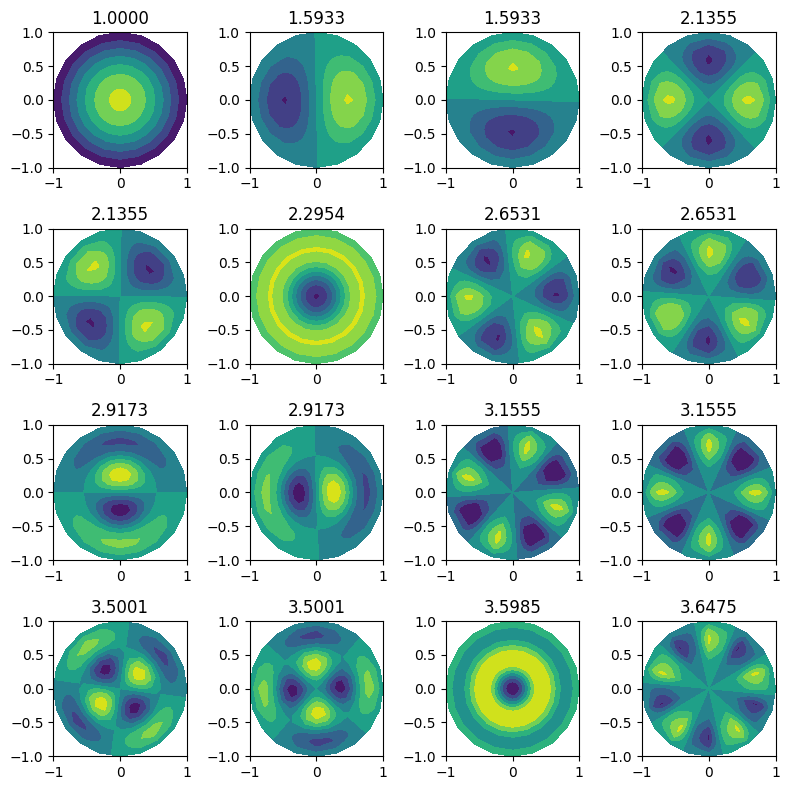

In [4]:
N = 35 # Number of points in Chebyshev radial grid
M = 20 # Number of points in Fourier angular grid
n = 4  # Number of modes per side of the grid

r, t, L = Laplacian(N,M)
lam2, V = eig(-L)

# Sort the eigenvalues and reshape
indices = np.argsort(lam2.real)
lam = np.sqrt(lam2.real[indices])
V   = V[:, indices].reshape(N//2, M, (N//2)*M).real

# Prepare the full r and theta grids in matrix form 
rr = np.ones((M + 1, 1)) @ np.concatenate([[[1]], r.T, [[0]]], axis = 1)
tt = np.concatenate([t, [[2*np.pi]]], axis = 0) @ np.ones((1, N//2 + 2))

# Complete the theta angle by identifying psi(r, 2*pi) = psi(r, 0)
V = np.concatenate([V, V[:, [0], :]], axis = 1)

# Reintroduce the boundary points as psi(1, theta) = 0
V = np.concatenate([np.zeros((1, M + 1, (N//2)*M)), V], axis = 0)

# Add point at r=0 as the average value of the neighboring ones, for nicer plots.
V = np.concatenate([V, np.mean(V[[-1], :, :], axis = 1) * np.ones((1, M + 1, (N//2)*M))], axis = 0) 

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(n, n, figsize = (8, 8));
plt.rc('font', size = 10)

for i in range(n):
    for j in range(n):
        ax[i, j].contourf(rr.T * np.cos(tt.T), rr.T * np.sin(tt.T), V[:, :, n*i + j])
        ax[i, j].set_title(f'{lam[n*i + j]/lam[0]:.4f}')
        
plt.tight_layout()
################################################################################